# Import

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib import rcParams
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

%matplotlib inline
#%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)


2.9.1


## load dataset

In [2]:
dataset = pd.read_csv('SecundaIMO3.csv', sep =';', header=0, index_col=0)
values = dataset.values

In [3]:
dataset.describe()

,O3,PM2.5,PM10,SO2,NO2,NO,NOx,CO,Amb Wspeed,Amb WDirection,Temperature,Amb RelHum,Amb Pressure,Rain
count,87647.000000,87647.000000,87647.000000,87647.000000,87647.000000,87647.000000,87647.000000,87647.000000,87647.000000,87647.000000,87647.000000,87647.000000,87647.000000,87647.000000
mean,29.554458,29.171659,61.765095,7.242098,17.605830,9.686645,26.121403,16.845333,1.881845,174.143041,15.839714,63.173814,848.373722,0.145777
std,24.132666,45.125576,98.996429,9.881698,19.608876,16.521904,29.015767,160.759570,1.387563,95.583791,7.438468,27.518155,11.924338,2.267876
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.210000,0.000000,0.000000,0.000000
25%,13.522600,8.525200,17.087900,2.005700,7.492000,2.433000,10.900000,0.089000,0.830000,79.020000,12.200000,42.060000,845.580000,0.000000
50%,27.750124,17.950000,37.304000,4.890000,13.717000,4.935000,19.317000,0.233000,1.800000,175.316333,16.216102,63.986725,848.471099,0.000000
75%,37.361400,31.456385,66.420114,7.737745,18.565700,9.878933,27.806900,1.000000,2.440000,256.780000,20.220000,88.870000,851.240000,0.000000
max,274.500000,1024.503000,4412.100000,306.293000,1009.120000,450.608000,490.957000,5101.800000,11.950000,359.990000,40.360000,103.780000,879.000000,246.000000


## Plot pm2.5

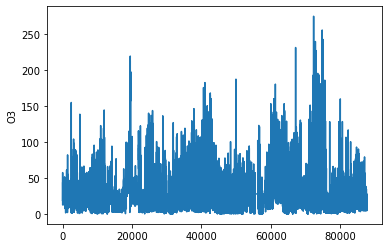

In [4]:
plt.plot(values[:,0])
plt.ylabel(dataset.columns[0])
plt.show()

## Data preparation

We need a way to prepare the data for whatever way we would like to formulate the problem.

In this case we are formulating it such that we take in 1 time step input (14 variables) and output 1 time step output (1 variable). In other words we are trying to solve the following question: given the pollution and weather conditions of the previous hour, can we predict the PM2.5 level for the next hour.

The single variable we are outputing is the PM2.5 level. Note we also use PM2.5 level in our input.

Credit for this code: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Get column names

In [6]:
dataset.columns

Index(['O3', 'PM2.5', 'PM10', 'SO2', 'NO2', 'NO', 'NOx', 'CO', 'Amb Wspeed',
       'Amb WDirection', 'Temperature', 'Amb RelHum', 'Amb Pressure', 'Rain'],
      dtype='object')

##Actually perform the data preparation

We scale the values between 0 and 1.

The code which converts the data into the suitable way we want, in this case, will produce 14 output variables. In our case we only want to predict PM2.5, that is why we drop the other collumns from the dataframe.

Credit for this code: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [7]:
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
# We drop these because we are only interested in predicting for a single variable (pollution).
# If we don't drop, then we will be predicting for all the variables too!
reframed.drop(reframed.columns[[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]], axis=1, inplace=True)
values = reframed.values

## View the data

In [8]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var1(t)
1,0.068915,0.009341,0.002724,0.011100,0.002253,0.002730,0.005174,0.000008,0.091213,0.590294,0.473337,0.963577,0.964391,0.0,0.083653
2,0.083653,0.004773,0.001281,0.011264,0.002089,0.002375,0.005479,0.000006,0.133054,0.354899,0.460366,0.963577,0.964130,0.0,0.110260
3,0.110260,0.010864,0.002736,0.010219,0.009678,0.003573,0.016519,0.000008,0.251883,0.194311,0.457896,0.914916,0.962036,0.0,0.075195
4,0.075195,0.008960,0.002235,0.014398,0.008230,0.003173,0.020939,0.000006,0.264435,0.164366,0.464072,0.853536,0.960557,0.0,0.095053
5,0.095053,0.006618,0.001772,0.012472,0.007440,0.003262,0.014299,0.000004,0.188285,0.205617,0.478279,0.785604,0.959420,0.0,0.109902


## Create X and Y variables

In [9]:
values.shape

(87646, 15)

In [10]:
X = values[:,:-1]

In [11]:
Y = values[:,-1]

## Check the shapes

In [12]:
X.shape

(87646, 14)

In [13]:
Y.shape

(87646,)

## Reshaping

The format that Keras expects is [batches, timesteps, features]

In [14]:
X = X.reshape(X.shape[0],X.shape[1])

In [15]:
X.shape

(87646, 14)

## Training, validation and testing split

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.20, random_state=42)

## Check the shape

In [17]:
print ('X_train:',X_train.shape)
print ('Y_train:',Y_train.shape)
print ()
print ('X_val:',X_val.shape)
print ('Y_val:',Y_val.shape)
print ()
print ('X_test:',X_test.shape)
print ('Y_test:',Y_test.shape)

X_train: (56092, 14)
Y_train: (56092,)

X_val: (14024, 14)
Y_val: (14024,)

X_test: (17530, 14)
Y_test: (17530,)


## Define a model

In [18]:
model = Sequential()
model.add(Dense(56, activation="relu", input_dim = 14))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='mse', optimizer='adam')

## Print summary

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 56)                840       
                                                                 
 dense_1 (Dense)             (None, 1)                 57        
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________


## Training

In [20]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),  epochs=50, batch_size=16,  verbose=1)

Epoch 1/50
3506/3506 [==============================] - 15s 4ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 2/50
3506/3506 [==============================] - 13s 4ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 3/50
3506/3506 [==============================] - 13s 4ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 4/50
3506/3506 [==============================] - 13s 4ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 5/50
3506/3506 [==============================] - 13s 4ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 6/50
3506/3506 [==============================] - 13s 4ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 7/50
3506/3506 [==============================] - 13s 4ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/50
3506/3506 [==============================] - 13s 4ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 9/50
3506/3506 [==============================] - 13s 4ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 10/50
3506/3506 [==============================] - 13s 4ms/step - l

## Predict

In [22]:
prediction = model.predict(X_test)

548/548 [==============================] - 2s 2ms/step


In [ ]:
def unscale(scaled_value):
    # if target variable is the first column, then, data_max_[0]
    unscaled_value = scaled_value * (scaler.data_max_[0] - scaler.data_min_[0]) + (scaler.data_min_[0])
    return unscaled_value

In [ ]:
predictions = unscale(prediction)

In [ ]:
Y_tests = unscale(Y_test)

In [23]:
mean_absolute_error(Y_tests, predictions)

0.023355486

In [26]:
rmse = sqrt(mean_squared_error(Y_tests, predictions))
print(rmse)

0.040450848349030365


In [27]:
r2_score(Y_tests, predictions)

0.7786365903667994

In [ ]:
print('accuracy testing = {}'.format(np.sum(prediction==Y_test)))

## Compare prediction and testing data

In [ ]:
rcParams['font.weight'] = 'bold'
plt.plot(Y_test[0:48], color='blue', label = 'Observed')
plt.plot(prediction[0:48], color='red', label = 'Predicted')
plt.ylabel('O3', fontname="Times New Roman", size=20,fontweight="bold")
plt.xlabel('Time(Hrs)', fontname="Times New Roman", size=20,fontweight="bold")
plt.title('Middelburg MLP', fontname="Times New Roman", size=28,fontweight="bold")
legend_properties = {'weight':'bold'}
plt.legend(prop=legend_properties)
plt.show()

In [ ]:
errors = predictions.flatten() - Y_tests

# Calculate quantiles based on actual values
quantiles, bins = pd.qcut(Y_tests, q=10, duplicates='drop', retbins=True)

# Calculate average error for each quantile
quantile_errors = []
for i in range(len(bins) - 1):
    group_indices = np.where((Y_tests >= bins[i]) & (Y_tests < bins[i+1]))[0]
    quantile_errors.append(errors[group_indices].mean())

# Round the bin edges for better readability
rounded_bins = np.round(bins, decimals=3)

# Plot quantiles vs. average errors
rcParams['font.weight'] = 'bold'
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(quantiles.categories) + 1), quantile_errors, marker='o')
plt.xlabel('Quantile', fontname="Times New Roman", size=20, fontweight="bold")
plt.ylabel('Average Error', fontname="Times New Roman", size=20, fontweight="bold")
plt.title('Quantile Analysis', fontname="Times New Roman", size=28, fontweight="bold")
plt.xticks(range(1, len(quantiles.categories) + 1), [f'{rounded_bins[i]:.3f} - {rounded_bins[i+1]:.3f}' for i in range(len(rounded_bins) - 1)], rotation=45)
plt.grid(True)
plt.show()

In [ ]:
mean_absolute_error(Y_test[1:6], prediction[1:6])

In [ ]:
mean_absolute_error(Y_test[1:12], prediction[1:12])

In [ ]:
mean_absolute_error(Y_test[1:18], prediction[1:18])

In [ ]:
mean_absolute_error(Y_test[1:24], prediction[1:24])

In [ ]:
mean_absolute_error(Y_test[1:36], prediction[1:36])

In [ ]:
mean_absolute_error(Y_test[1:48], prediction[1:48])

In [ ]:
rmse = sqrt(mean_squared_error(Y_test[1:6], prediction[1:6]))
print(rmse)

In [ ]:
rmse = sqrt(mean_squared_error(Y_test[1:12], prediction[1:12]))
print(rmse)

In [ ]:
rmse = sqrt(mean_squared_error(Y_test[1:18], prediction[1:18]))
print(rmse)

In [ ]:
rmse = sqrt(mean_squared_error(Y_test[1:24], prediction[1:24]))
print(rmse)

In [ ]:
rmse = sqrt(mean_squared_error(Y_test[1:36], prediction[1:36]))
print(rmse)

In [ ]:
rmse = sqrt(mean_squared_error(Y_test[1:48], prediction[1:48]))
print(rmse)